In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.func import vmap, jacrev
from tqdm import tqdm
import os
import random
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import Callback
import math
from pydmd import DMD
from sklearn.preprocessing import MinMaxScaler
import warnings
from matplotlib.font_manager import FontProperties

In [2]:
class ResidualFlow(nn.Module):
    def __init__(self, dim, hidden_dim, input_dim=0, dropout=0, LDJ=False):
        super(ResidualFlow, self).__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.LDJ = LDJ
        self.dropout = dropout
        self.n_layers = 1
        
        layers = [nn.Linear(self.dim + self.dim * (self.input_dim > 0), self.hidden_dim), nn.ReLU()]
        for _ in range(self.n_layers):
            layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(self.hidden_dim, self.dim))
        self.net = nn.Sequential(*layers)
        if self.input_dim > 0:
            self.cheby = nn.Linear(self.input_dim, self.dim - self.input_dim)
        self._initialize_weights()
    
    def forward(self, x, u=None, reverse=False):
        def func(x_):
            x_e = torch.cat((x_, u_), dim=-1) if u is not None else x_
            return self.net(x_e)
        if u is not None:
            u = F.tanh(u) / (1+1e-3)
            chebyshev = torch.cos(self.cheby(torch.arccos(u)))
            u = torch.cat((u, chebyshev), dim=-1)
        if not reverse:   
            y = x + func(x)
            if self.LDJ:
                x = x.view(-1, x.shape[-1])
                u = u.view(-1, u.shape[-1]) if u is not None else None
                jacobian = vmap(jacrev(func))(x)
                jacobian = jacobian.clone()  
                jacobian.diagonal(dim1=-2, dim2=-1).add_(1.0)
                _, logdet = torch.linalg.slogdet(jacobian)
                logdet = logdet.sum()
            else:
                logdet = 0
            return y, logdet
        else:
            y = x
            epsilon = 1e-6
            det = 1
            max_iter = 1000
            with torch.no_grad():
                for _ in range(max_iter):
                    y_temp = y
                    y = x - func(y)
                    det = torch.norm(y - y_temp, dim=-1).max()
                    if det < epsilon:
                        break  
            return y
    
    def _initialize_weights(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear):
                if 'cheby' in name:
                    lambda_s = 5
                    module.weight.data = torch.distributions.exponential.Exponential(lambda_s).sample(module.weight.shape)
                else:
                    nn.init.xavier_uniform_(module.weight)
                    if module.bias is not None:
                        nn.init.zeros_(module.bias)

class InvertibleNN(nn.Module):
    def __init__(self, dim, hidden_dim, n_blocks, input_dim=0, dropout=0, LDJ=False):
        super(InvertibleNN, self).__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.n_blocks = n_blocks
        self.input_dim = input_dim
        self.blocks = nn.ModuleList([ResidualFlow(self.dim, self.hidden_dim, self.input_dim, dropout, LDJ) for _ in range(self.n_blocks)])
    
    def forward(self, x, u=None, reverse=False):
        if not reverse:
            ldj_total = 0
            for block in self.blocks:
                x, ldj = block(x, u, reverse)
                ldj_total += ldj
            return x, ldj_total
        else:
            for block in reversed(self.blocks):
                x = block(x, u, reverse)
            return x
    
class CombinedNetwork(nn.Module):
    def __init__(self, inn_model, input_dim, lifted_dim, Xmax, Xmin):
        super(CombinedNetwork, self).__init__()
        self.input_dim = input_dim
        self.inn_model = inn_model  
        self.Xmax = Xmax
        self.Xmin = Xmin
        self.dropout = nn.Dropout(p=inn_model.blocks[0].dropout)
        self.linear = nn.Linear(input_dim, lifted_dim, bias=False)  
        self.K = nn.Parameter(torch.randn(input_dim + lifted_dim, input_dim + lifted_dim), requires_grad=True)
        self._initialize_weights()
    
    def forward(self, x, u=None, reverse=False):
        x = x.float()
        Xmax = self.Xmax.to(x.device)
        Xmin = self.Xmin.to(x.device)
        if not reverse:
            x = (x - Xmin) / (Xmax - Xmin)
            chebyshev = torch.cos(self.linear(torch.arccos(x)))
            x = torch.cat((x, chebyshev), dim=-1)
            # x = self.dropout(x)
            x, ldj = self.inn_model(x, u, reverse)
            return x, ldj
        else:
            x = self.inn_model(x, u, reverse)
            x = x[:, :self.input_dim]
            x = (Xmax - Xmin) * x + Xmin
            return x
    
    def _initialize_weights(self):
        lambda_s = 5
        self.linear.weight.data = torch.distributions.exponential.Exponential(lambda_s).sample(self.linear.weight.shape)

In [3]:
def dmd(model, X, rank):
    GX_pred_list = []
    GX_list = []
    GX, ldj = model(X)
    U_, S, Vh = torch.linalg.svd(model.K, full_matrices=False)
    S_r = S[:rank]                     
    U_r = U_[:, :rank]                 
    Vh_r = Vh[:rank, :]           
    K_r = U_r @ torch.diag(S_r) @ Vh_r
    for i in range(X.shape[0]):
        GX_temp = GX[i, :, :].T
        GX_pred = K_r @ GX_temp[:, :-1]
        GX_pred_list.append(GX_pred)
        GX_list.append(GX_temp[:, 1:])
    GX_pred = torch.cat(GX_pred_list, dim=-1)
    GX = torch.cat(GX_list, dim=1)

    return GX, GX_pred, ldj

In [4]:
class TrainModel(pl.LightningModule):
    def __init__(self, model, rank, learning_rate=1e-3, lamb=1, path="model_checkpoint_NP"):
        super(TrainModel, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = nn.MSELoss()
        self.best_val_loss = float('inf')  
        self.validation_outputs = []
        self.lamb = lamb
        self.train_losses = []
        self.rank = rank
        self.path = path+'.ckpt'

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        X_batch = batch[0]
        GY, GY_pred, ldj = dmd(self.model, X_batch, self.rank)

        loss_lin = self.criterion(GY, GY_pred)
        loss_LDJ = ldj / X_batch.numel()

        loss = loss_lin - self.lamb * loss_LDJ
        self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        Z_batch = batch[0]
        Z1, Z_pred, _ = dmd(self.model, Z_batch, self.rank)
        Z_pred = self.model(Z_pred.T, reverse=True)
        Z1 = self.model(Z1.T, reverse=True)
        valid_loss = self.criterion(Z_pred, Z1)

        self.validation_outputs.append(valid_loss)
        self.log('val_loss', valid_loss)
        return valid_loss

    def test_step(self, batch, batch_idx):
        Z_batch = batch[0]
        Z1, Z_pred, _ = dmd(self.model, Z_batch, self.rank)
        Z_pred = self.model(Z_pred.T, reverse=True)
        Z1 = self.model(Z1.T, reverse=True)
        test_loss = self.criterion(Z_pred, Z1)

        self.log('test_loss', test_loss)
        return test_loss
    
    def on_train_batch_end(self, outputs, batch, batch_idx):
        with torch.no_grad():  
            for name, module in self.model.named_modules():  
                if isinstance(module, nn.Linear): 
                    if name == "linear":  
                        continue
                    weight = module.weight  
                    sigma_max = torch.linalg.norm(weight, ord=2)  
                    if sigma_max > 1:  
                        scale = (1 - 1e-3) / sigma_max
                        module.weight.data *= scale  
            radius = torch.linalg.norm(self.model.K.data, ord=2)
            self.model.K.data = self.model.K.data / radius
    
    def on_train_epoch_start(self):
        if os.path.exists(self.path):
            best_state_dict = torch.load(self.path)["state_dict"]
            self.load_state_dict(best_state_dict)
    
    def on_train_epoch_end(self):
        if self.trainer.is_global_zero:  
            avg_train_loss = self.trainer.callback_metrics.get("train_loss")
            if avg_train_loss is not None:
                self.train_losses.append(avg_train_loss.item())  
                print(f"Epoch {self.current_epoch}: Average Training Loss = {avg_train_loss.item()}")

    def on_validation_epoch_end(self):
        avg_val_loss = torch.stack(self.validation_outputs).mean() 
        self.log('avg_val_loss', avg_val_loss)
        self.validation_outputs.clear()
        print(f"Validation loss: {avg_val_loss}")
        with open("loss_log.txt", "a") as f:
            f.write(f"{avg_val_loss.item()}\n")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-3)
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #     optimizer,
        #     mode='min',
        #     factor=0.5,
        #     patience=5,
        #     cooldown=1
        # )
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=100,
            gamma=0.5
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss", 
            },
            "gradient_clip_val": 1.0,  
            "gradient_clip_algorithm": "norm",
        }

In [5]:
dim = 8
hidden_dim = 80  
input_dim = 0
n_blocks = 3  
n_feature = 12
rank = 20
batch_size = 1
# n_train = 6400
n_train = 1
# n_valid = 1000
n_test = 1
dropout = 0
num_epochs = 9999  
lamb = 1e-3
learning_rate = 1e-3  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
X_train = pd.read_csv('y_train.csv', header=None).values.astype(float)
length = X_train.shape[1] // n_train
H_train = []
for i in range(n_train):
    H_train.append(X_train[:, i*length:(i+1)*length])
H_train = np.stack([H_train[idx].T for idx in range(n_train)], axis=0)
train_dataset = TensorDataset(torch.tensor(H_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

X_result = np.concatenate([X_train], axis=-1)
Xmax = torch.tensor(np.max(X_result, axis=-1), dtype=torch.float)
Xmin = torch.tensor(np.min(X_result, axis=-1), dtype=torch.float)

In [7]:
inn_model = InvertibleNN(dim=dim+n_feature, hidden_dim=hidden_dim, n_blocks=n_blocks, input_dim=input_dim, dropout=dropout, LDJ=lamb>0)
model = CombinedNetwork(inn_model=inn_model, input_dim=dim, lifted_dim=n_feature, Xmax=Xmax, Xmin=Xmin)
path = "model_checkpoint_Wave.ckpt"
lightning_model = TrainModel.load_from_checkpoint(path, model=model, rank=rank, learning_rate=learning_rate, map_location="cpu")
trainer = pl.Trainer(accelerator="gpu", devices=4, strategy="ddp_notebook", max_epochs=num_epochs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [ ]:
warnings.filterwarnings("ignore")
trainer.test(lightning_model, dataloaders=train_loader)

In [9]:
i = 0
X_traj = H_train
GY, GY_pred, _ = dmd(lightning_model.model, torch.tensor(X_traj, dtype=torch.float32), rank)
X_recons = lightning_model.model(GY_pred.T.cpu(), reverse=True).T.detach().numpy()

In [12]:
lamb = 0.001

noise = torch.sqrt(torch.tensor(lamb / 2, device=GY_pred.device)) * torch.randn(100, GY_pred.shape[0], GY_pred.shape[1], device=GY_pred.device)
GY_noise = GY_pred[None, :, :] + noise
X_recons_list = []
for i in range(100):
    X_recons = lightning_model.model(GY_noise[i, :, :].cpu().T, reverse=True).T.detach().numpy()
    X_recons_list.append(X_recons)
X_recons = np.stack(X_recons_list, axis=0)
median_traj = np.median(X_recons, axis=0)
q_low = np.percentile(X_recons, 2.5, axis=0)
q_high = np.percentile(X_recons, 97.5, axis=0)

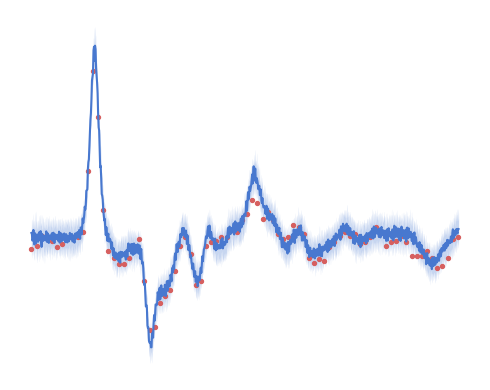

In [13]:
from scipy.interpolate import interp1d

t = np.linspace(0.01, 0.61, num=length-1)
median_traj = np.median(X_recons, axis=0)
q_low = np.percentile(X_recons, 2.5, axis=0)
q_high = np.percentile(X_recons, 97.5, axis=0)

interp_factor = 10
t_new = np.linspace(t.min(), t.max(), len(t) * interp_factor)

f_med = interp1d(t, median_traj[1, :], kind='cubic')
f_low = interp1d(t, q_low[1, :], kind='cubic')
f_high = interp1d(t, q_high[1, :], kind='cubic')

smooth_median = f_med(t_new)
smooth_low = f_low(t_new)
smooth_high = f_high(t_new)

plt.figure(figsize=(5, 4))

plt.plot(t_new[::18], smooth_median[::18], color="#4878CF", linewidth=1.5, label='Median')

plt.fill_between(t_new, smooth_low, smooth_high, color="#4878CF", linewidth=0, alpha=0.3, label='95% CI')

plt.scatter(t[::18], X_traj[0, 1:length:18, 0], color='#D65F5F', s=8, linewidths=1.0, label='Test')

# plt.plot(smooth_x, smooth_y, color="#0072B2", linewidth=1.5, label='Reconstructed', zorder=1)

# plt.scatter(
#     t, X_traj[0, 1:751, 0]
#     facecolors='none',
#     edgecolors='#DAA520',
#     s=30,
#     linewidth=1.5,
#     label='Test',
#     zorder=2
# )

plt.axis('off')

plt.tight_layout()
plt.savefig("f2.svg", format='svg', bbox_inches='tight')
plt.show()

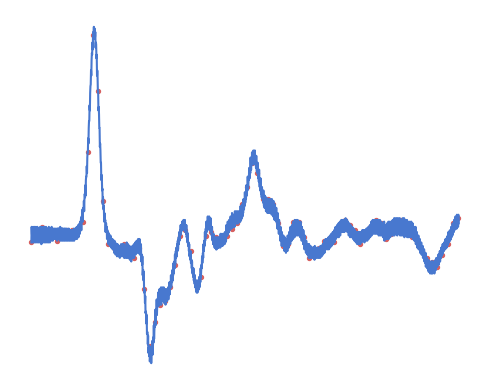

In [14]:
from matplotlib.font_manager import FontProperties
from scipy.interpolate import interp1d

arial_font = FontProperties(fname="/root/.fonts/arial.ttf", size=19.5)

t = np.linspace(0.01, 0.61, num=length-1)
plt.figure(figsize=(5, 4))

plt.plot(t, X_traj[0, 1:, 1], color="#4878CF", linewidth=1.5, label='Reconstructed')

plt.scatter(t[::18], X_traj[0, 1:length:18, 1],
            s=8, color="#D65F5F",
            linewidths=1.0, label='Test')

# plt.xlabel('$x_1$', fontsize=19.5)
# plt.ylabel('$x_2$', fontsize=19.5)
# plt.xticks(fontsize=8, fontproperties=arial_font)
# plt.yticks(fontsize=8, fontproperties=arial_font)
plt.xticks([])
plt.yticks([])

# plt.legend(
#     loc='lower center',
#     bbox_to_anchor=(0.5, 1.02),
#     borderaxespad=0.3,
#     ncol=2,
#     columnspacing=0.5,
#     handletextpad=0.4,
#     handlelength=0.5,
#     frameon=False,
#     fontsize=8,
#     prop=arial_font
# )

# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.gca().axis('off')
plt.savefig("f1.svg", format='svg', bbox_inches='tight')
plt.show()

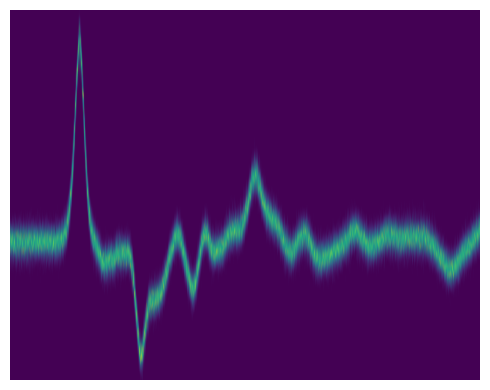

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D

num, dim, length2 = X_recons.shape
np.random.seed(0)
array = X_recons

n = 1  
bins = 1000  

selected = array[:, n, :]

x_min, x_max = np.min(selected), np.max(selected)
x_grid = np.linspace(x_min, x_max, bins)

p_x_t = []
for t in range(selected.shape[1]):
    kde = gaussian_kde(selected[:, t])
    p = kde.evaluate(x_grid)
    p_x_t.append(p)

p_x_t = np.array(p_x_t)  # shape (len, bins)

plt.figure(figsize=(5, 4))
plt.imshow(
    p_x_t.T, 
    extent=[0, length2, x_min, x_max], 
    aspect='auto', 
    origin='lower', 
    cmap='viridis'
)
plt.xticks([])
plt.yticks([])

# plt.colorbar(label='Density p(x, t)')
# plt.xlabel('Time (t)')
# plt.ylabel('Space (x)')
# plt.title(f'Heatmap of Density over Time for Dimension {n}')
plt.tight_layout()
plt.gca().axis('off')
plt.savefig("f4.svg", format='svg', bbox_inches='tight')
plt.show()

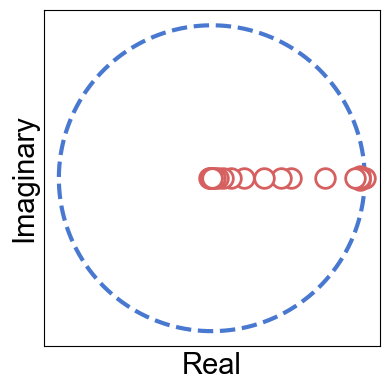

In [31]:
from matplotlib.colors import LinearSegmentedColormap

arial_font = FontProperties(fname="/root/.fonts/arial.ttf", size=21)

eigenvalues, eigenvectors = torch.linalg.eig(lightning_model.model.K)
eigs = eigenvalues.detach().numpy()

theta = np.linspace(0, 2 * np.pi, 500)
unit_circle_x = np.cos(theta)
unit_circle_y = np.sin(theta)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(unit_circle_x, unit_circle_y, linestyle='--', color="#4878CF", zorder=1, linewidth=3)

scatter = ax.scatter(
    eigs.real,
    eigs.imag,
    c="white",          
    s=200,
    linewidths=2.0, alpha=1,
    edgecolors="#D65F5F",
    zorder=2
)

ax.set_aspect('equal')
ax.grid(False)
plt.xlabel("Real", fontsize=21, fontproperties=arial_font)
plt.ylabel("Imaginary", fontsize=21, fontproperties=arial_font)
plt.xticks([], fontsize=8, fontproperties=arial_font)
plt.yticks([], fontsize=8, fontproperties=arial_font)

plt.tight_layout()
plt.savefig("mode31.svg", format='svg', bbox_inches='tight')
plt.show()

In [10]:
eigvals, eigvecs = torch.linalg.eig(lightning_model.model.K)
abs_eigvals = eigvals.abs()
sorted_indices = torch.argsort(abs_eigvals, descending=True)
eigvals_sorted = eigvals[sorted_indices]  
eigvecs_sorted = eigvecs[:, sorted_indices] 

In [11]:
eigvals_sorted

tensor([ 0.9999+0.0000j,  0.9690+0.0139j,  0.9690-0.0139j,  0.9684+0.0000j,
         0.9339+0.0000j,  0.7416+0.0000j,  0.5163+0.0000j,  0.4521+0.0000j,
         0.3421+0.0000j,  0.2091+0.0000j,  0.1253+0.0000j,  0.0713+0.0000j,
         0.0384+0.0000j,  0.0212+0.0000j, -0.0153+0.0000j, -0.0098+0.0000j,
        -0.0070+0.0000j, -0.0039+0.0000j,  0.0028+0.0000j, -0.0015+0.0000j],
       grad_fn=<IndexBackward0>)

In [12]:
GX_all = lightning_model.model(torch.tensor(H_train, dtype=torch.float32))[0].reshape(-1, dim+n_feature)
X_all = X_train.T
phi_0 = GX_all.to(torch.complex64) @ eigvecs_sorted[:, 0]
magnitude_0 = torch.abs(phi_0).cpu().detach().numpy()
phase_0 = torch.angle(phi_0).cpu().detach().numpy()
phi_0 = phi_0.cpu().detach().numpy()
phi_1 = GX_all.to(torch.complex64) @ eigvecs_sorted[:, 1]
magnitude_1 = torch.abs(phi_1).cpu().detach().numpy()
phase_1 = torch.angle(phi_1).cpu().detach().numpy()
phi_1 = phi_1.cpu().detach().numpy()
phi_2 = GX_all.to(torch.complex64) @ eigvecs_sorted[:, 2]
magnitude_2 = torch.abs(phi_2).cpu().detach().numpy()
phase_2 = torch.angle(phi_2).cpu().detach().numpy()
phi_2 = phi_2.cpu().detach().numpy()

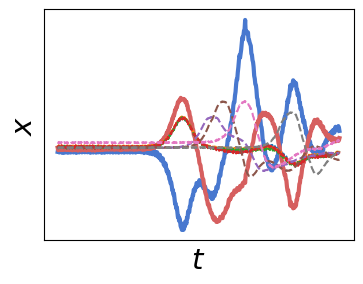

In [39]:
length = 500
plt.figure(figsize=(4, 3))
plt.plot(np.real(phi_1[:length]), linewidth=3, color="#4878CF")
plt.plot(np.imag(phi_1[:length]), linewidth=3, color='#D65F5F')
for i in range(X_all.shape[1]):
    if i == 0:
        plt.plot(10*X_all[:length, i], '--', label='Measurements')
    else:
        plt.plot(10*X_all[:length, i], '--') 
plt.xticks([], fontsize=8, fontproperties=arial_font)
plt.yticks([], fontsize=8, fontproperties=arial_font)
plt.xlabel("$t$", fontsize=21, fontproperties=arial_font)
plt.ylabel("$x$", fontsize=21, fontproperties=arial_font)
plt.savefig("mode32.svg", format='svg', bbox_inches='tight')